# Demonstration of Well Class

Notebook to demonstrate using the `Well` Class to 
estimate drawdown or stream depletion using the 
solutions available in the python module.

In [1]:
import sys

sys.path.insert(1, "../../")
import pycap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Example Depletion
The `Well` class will estimate depletions for streams.  The stream distances and
streambed conductances, if needed, are passed through dictionaries keyed by 
a stream name or ID.  In this notebook a table of values will be made manually from 
Table 2 from Reeves, H.W., Hamilton, D.A., Seelbach, P.W., and Asher, A.J., 2009, Ground-water-withdrawal component of the Michigan water-withdrawal screening tool: U.S. Geological Survey Scientific Investigations Report 2009–5003, 36 p.
[https://pubs.usgs.gov/sir/2009/5003/]

>   pro tip: notice that the distance increases with increasing ID number. Useful for relative reference below.

In [2]:
stream_table = pd.DataFrame(
    (
        {"id": 8, "distance": 14802},
        {"id": 9, "distance": 12609.2},
        {"id": 11, "distance": 15750.5},
        {"id": 27, "distance": 22567.6},
        {"id": 9741, "distance": 27565.2},
        {"id": 10532, "distance": 33059.5},
        {"id": 11967, "distance": 14846.3},
        {"id": 12515, "distance": 17042.55},
        {"id": 12573, "distance": 11959.5},
        {"id": 12941, "distance": 19070.8},
        {"id": 13925, "distance": 10028.9},
    )
)

## Compute apportionment

The example in the report uses inverse-distance weighting apportionment.  Other
apportionment approaches that may be used as a simple way to extend the analytical
solution are discussed by Zipper and others (2019).  [https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018WR024403]

In [3]:
invers = np.array([1 / x for x in stream_table["distance"]])
stream_table["apportionment"] = (1.0 / stream_table["distance"]) / np.sum(invers)

## set aquifer properties and streambed conductances

In [4]:
T = 7211.0  # ft^2/day
S = 0.01
Q = 70  # 70 gpm --> must convert to cubic feet per day
pumpdays = int(5.0 * 365)
stream_table["conductance"] = 7.11855  # example uses constant streambed_conductance

## call a utility to convert Q to a series with appropriate formatting

The `Well` Class works with a Pandas series of pumping rates, it may be
easily constructed with the `pycap-dss` `Q2ts` function.  The index of the
series is pumping days.  We also need to convert 
from pumping in GPM to cubic feet per day so that units are consistent.


In [5]:
Q = pycap.Q2ts(pumpdays, 5, Q) * pycap.GPM2CFD

In [6]:
Q

1       13475.935829
2       13475.935829
3       13475.935829
4       13475.935829
5       13475.935829
            ...     
1821    13475.935829
1822    13475.935829
1823    13475.935829
1824    13475.935829
1825    13475.935829
Length: 1825, dtype: float64

In [7]:
stream_table.head()

,id,distance,apportionment,conductance
0,8,14802.0,0.098916,7.11855
1,9,12609.2,0.116118,7.11855
2,11,15750.5,0.092959,7.11855
3,27,22567.6,0.064878,7.11855
4,9741,27565.2,0.053116,7.11855


make dictionaries from the distances, apportionment, and conductance values

In [8]:
distances = dict(zip(stream_table.id.values, stream_table.distance.values))

In [9]:
apportion = dict(zip(stream_table.id.values, stream_table.apportionment.values))

In [10]:
cond = dict(zip(stream_table.id.values, stream_table.conductance.values))

## Make a Well object

Depletion and drawdown can be easily returned as attributes of the object.
The choice of depletion or drawdown method is made through a parameter passed to
the object.  In this example the Hunt (1999) depletion method is used
to compute stream depletion for the dictionary of streams at the given
distances with the inverse-distance apportionment.  We also can
compute drawdown at a dictionary of locations.  If drawdown_dist
is not passed to the object, then drawdowns will not be computed.
Results are returned as arrays that may easily be converted to 
Pandas dataframes for ease of viewing and plotting.

In [11]:
test_well = pycap.Well(
    T=T,
    S=S,
    Q=Q,
    depletion_years=5,
    depl_method="hunt_99_depletion",
    drawdown_dist={"testlocation0": 50.0},  # default method is Theis
    streambed_conductance=cond,
    stream_dist=distances,
    stream_apportionment=apportion,
)

In [12]:
drawdown = pd.DataFrame(test_well.drawdown)

look at drawdown, only one distance was specified. The timeseries is returned however.

In [13]:
drawdown.head()

,testlocation0
0,0.000000
1,0.962843
2,1.065859
3,1.126136
4,1.168908


### Depletion

The object gives the daily time series according to the 
pumping schedule.  We can pull out the 5-year depletion
to note that the final results match Table 2. Note that
we need to convert to GPM to compare results to Table 2

In [14]:
stream_depl = pd.DataFrame(test_well.depletion)

In [15]:
stream_depl = stream_depl * pycap.CFD2GPM
# pull out row for days = 1824 and transpose matrix for ease of comparison to Table 2
five_year = pd.DataFrame(stream_depl.loc[1824].T)
five_year.rename(columns={1824: "Depletion"}, inplace=True)
five_year

,Depletion
8,5.144899
9,6.303955
11,4.744429
27,2.869554
9741,2.098081
10532,1.532334
11967,5.125042
12515,4.271490
12573,6.729668
12941,3.660252


## What about plotting?

Text(0, 0.5, 'drawdown in feet')

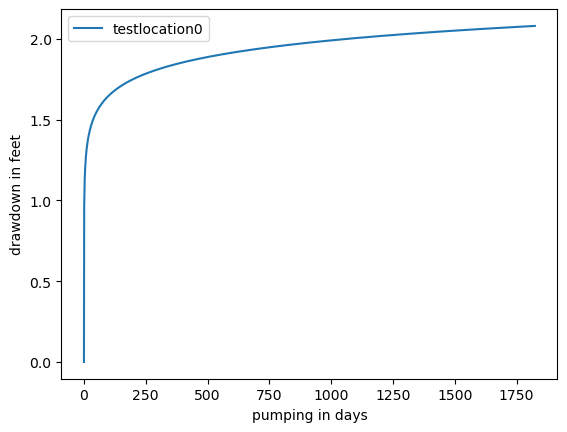

In [16]:
fig, ax = plt.subplots()
drawdown.plot(ax=ax)
ax.set_xlabel("pumping in days")
ax.set_ylabel("drawdown in feet")

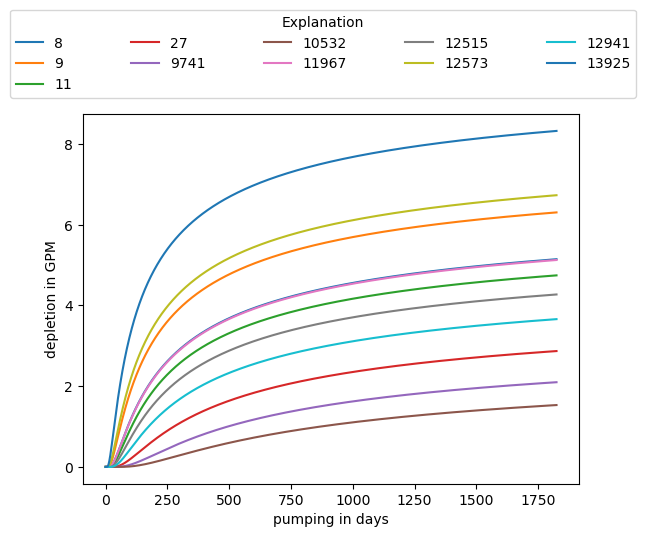

In [17]:
fig, ax = plt.subplots()
stream_depl.plot(ax=ax)
ax.set_xlabel("pumping in days")
ax.set_ylabel("depletion in GPM")
ax.legend(
    title="Explanation",
    bbox_to_anchor=(0, 0.9, 1, 0.9),
    bbox_transform=fig.transFigure,
    ncols=5,
    mode="expand",
    loc="lower left",
)

## Change depletion method
Several depletion methods are available (see the solutions demonstation notebook
for more information).  The choice of depletion method is passed to the object
as a parameter.  Some solutions require additional parameters which need
to be passed as named variables.

In [18]:
pycap.ALL_DEPL_METHODS

{'glover_depletion': <function pycap.solutions.glover_depletion(T, S, time, dist, Q, **kwargs)>,
 'walton_depletion': <function pycap.solutions.walton_depletion(T, S, time, dist, Q, **kwargs)>,
 'hunt_99_depletion': <function pycap.solutions.hunt_99_depletion(T, S, time, dist, Q, streambed_conductance=None, **kwargs)>,
 'hunt_03_depletion': <function pycap.solutions.hunt_03_depletion(T, S, time, dist, Q, Bprime=None, Bdouble=None, aquitard_K=None, sigma=None, width=None, streambed_conductance=None, **kwargs)>,
 'dudley_ward_lough_depletion': <function pycap.solutions.dudley_ward_lough_depletion(T1, S1, time, dist, Q, T2=None, S2=None, width=None, streambed_thick=None, streambed_K=None, aquitard_thick=None, aquitard_K=None, NSteh1=2, **kwargs)>}

In [19]:
# for example the Glover and Balmer solution for a stream assuming no streambed resistance. Note that
# the streambed_conductance parameter can be dropped from the call.
test_glover = pycap.Well(
    T=T,
    S=S,
    Q=Q,
    depletion_years=5,
    depl_method="glover_depletion",
    drawdown_dist={"testlocation0": 50.0},  # default method is Theis
    stream_dist=distances,
    stream_apportionment=apportion,
)

In [20]:
glover_depl = pd.DataFrame(test_glover.depletion)
glover_depl = glover_depl * pycap.CFD2GPM

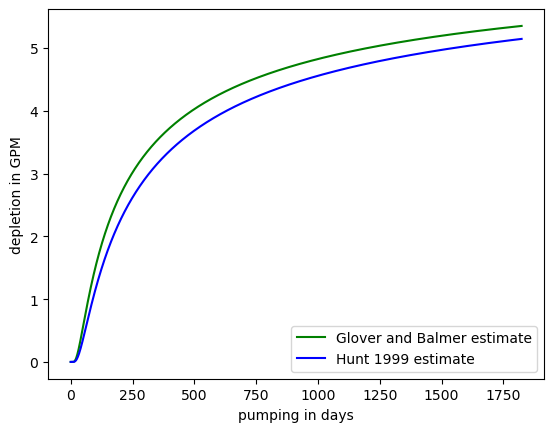

In [21]:
# plot the two solutions to compare depletion estimates

fig, ax = plt.subplots()
ax.plot(
    glover_depl.index.values,
    glover_depl[8].values,
    "g-",
    label="Glover and Balmer estimate",
)
ax.plot(
    stream_depl.index.values, stream_depl[8].values, "b-", label="Hunt 1999 estimate"
)
ax.set_xlabel("pumping in days")
ax.set_ylabel("depletion in GPM")
ax.legend(loc="lower right")

## Intermittent Pumping
The `Well` Class accepts Q as a series of daily pumping rates and will
use superposition to produce a timeseries of drawdown or depletion.
The `Q2ts` helper function is one way to generate an input series, 
but the user can make an arbitrary series.


Set up a series pumping 3 days a week during June, July, and August

In [22]:
Q_series = pd.Series(
    index=pd.period_range(start="2020-10-01", end="2025-09-30", freq="D")
)

In [23]:
for d in Q_series.index.values:
    Q_series[d] = 0.0
    if d.month in range(6, 9):
        if d.dayofweek in range(3, 6):
            Q_series[d] = 70 * pycap.GPM2CFD

(18779.0, 18871.0)

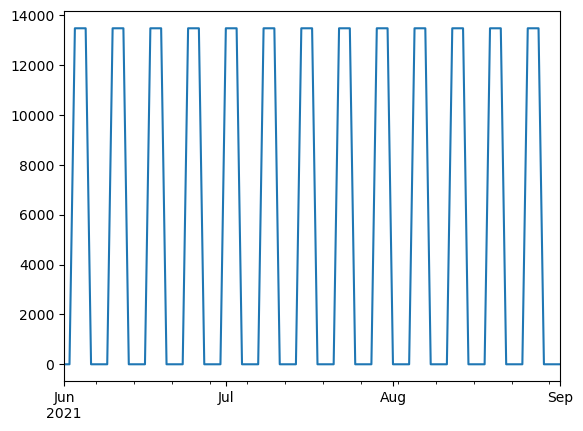

In [24]:
fig, ax = plt.subplots()
Q_series.plot(ax=ax)
ax.set_xlim("2021-06-01", "2021-09-01")

`Well` Class expects series index to be integer days

In [25]:
Q_days = pd.Series(Q_series.values, index=range(1, len(Q_series) + 1))

In [26]:
Q_days

1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
1822    0.0
1823    0.0
1824    0.0
1825    0.0
1826    0.0
Length: 1826, dtype: float64

In [27]:
test_intermittent = pycap.Well(
    T=T,
    S=S,
    Q=Q_days,
    depletion_years=5,
    depl_method="hunt_99_depletion",
    drawdown_dist={"testlocation0": 50.0},  # default method is Theis
    streambed_conductance=cond,
    stream_dist=distances,
    stream_apportionment=apportion,
)

In [28]:
intermittent_depl = pd.DataFrame(test_intermittent.depletion) * pycap.CFD2GPM

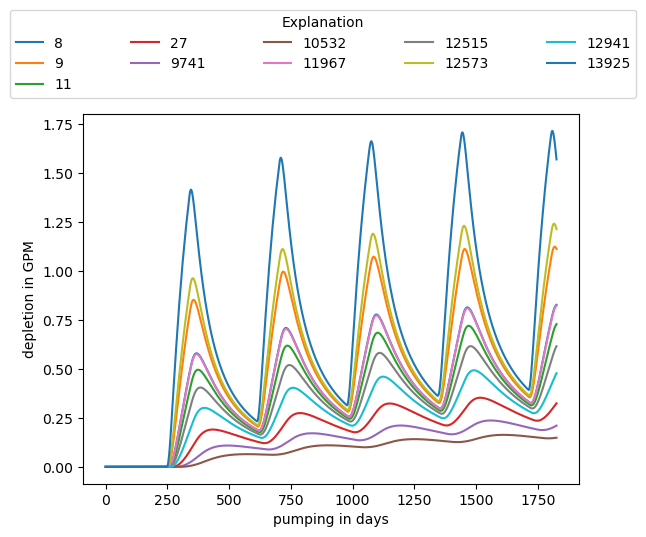

In [29]:
fig, ax = plt.subplots()
intermittent_depl.plot(ax=ax)
ax.set_xlabel("pumping in days")
ax.set_ylabel("depletion in GPM")
ax.legend(
    title="Explanation",
    bbox_to_anchor=(0, 0.9, 1, 0.9),
    bbox_transform=fig.transFigure,
    ncols=5,
    mode="expand",
    loc="lower left",
)

Recall from above that only a single drawdown location was passed to the `Well` 

In [30]:
intermittent_drawdown = pd.DataFrame(test_intermittent.drawdown)

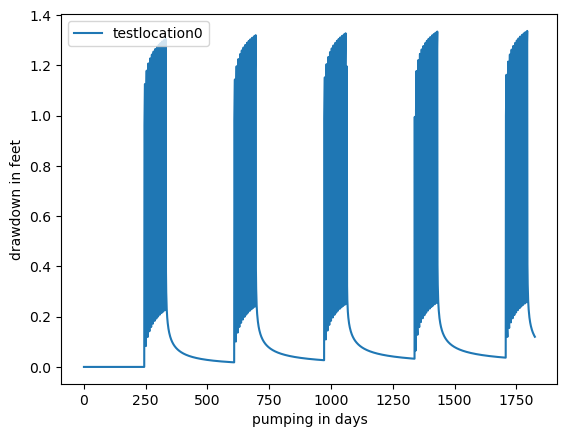

In [31]:
fig, ax = plt.subplots()
intermittent_drawdown.plot(ax=ax)
ax.set_xlabel("pumping in days")
ax.set_ylabel("drawdown in feet")
ax.legend(loc="upper left")

## Well Class is restricted to Theis drawdown

There are drawdown estimates using the Hunt (1999) and 
Ward and Lough (2011) solutions; but the Well Class is not 
currently set up to use these solutions.  The user should
call the functions directly.

Uncomment the following block and run it to see the error in trying to use other drawdown functions.

In [32]:
# test_intermittent = pycap.Well(T=T,
#                  S=S,
#                  Q=Q_days,
#                  depletion_years=5,
#                  depl_method='hunt_99_depletion',
#                  drawdown_dist={'testlocation0':50.},  #default method is Theis
#                  drawdown_method='hunt_99_drawdown',
#                  streambed_conductance=cond,
#                  stream_dist=distances,
#                  stream_apportionment=apportion)